# 📋 PII-Redaktion --> LLM

**Ziel dieses Notebooks**: PII vor der Verarbeitung durch LLMs erkennen und maskieren!

### Was sind personenbezogene Daten (PII)?

**Personally Identifiable Information (PII)** bezeichnet alle Informationen, die dazu verwendet werden können, eine Person direkt oder indirekt zu identifizieren:

| Kategorie | Beispiele |
|-----------|----------|
| Direkte Identifikatoren | Name, E-Mail, Telefonnummer |
| Indirekte Identifikatoren | Geburtsdatum, Adresse, IP-Adresse |
| Sensible Daten | Sozialversicherungsnummer, Kreditkartendaten, IBAN |

### Warum ist das ein Problem bei LLMs?

Large Language Models werden auf riesigen Textkorpora trainiert, die unbeabsichtigt PII enthalten können:

-  **Training Data Extraction**: Carlini et al. (2021) haben in ihrer Studie "Extracting Training Data from Large Language Models" gezeigt, dass LLMs trainierte Daten "auswendig lernen" und unter bestimmten Prompts wieder ausgeben können. Sie konnten Namen, E-Mail-Adressen und sogar Telefonnummern aus GPT-2 extrahieren.

### Existierende Tools: Microsoft Presidio

Für die PII-Erkennung gibt es etablierte Open-Source-Lösungen wie [Microsoft Presidio](https://github.com/microsoft/presidio). Presidio bietet:
- Vorgefertigte Recognizer für viele PII-Typen
- Unterstützung für verschiedene Sprachen
- Integration mit NLP-Modellen (spaCy, Transformers)

---

## Setup & Imports

In [36]:
# Installation der Dependencies --> nur beim ersten Mal nötig
#!pip install spacy transformers torch pandas matplotlib seaborn llama-cpp-python rouge-score
#!python -m spacy download de_core_news_lg

In [37]:
import sys
import os
from pathlib import Path

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import re
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

# PII-Redactor --> eigener
from src.pii_redactor import PIIRedactor, PIIType, RedactionResult

print("Alle Imports erfolgreich!")

Alle Imports erfolgreich!


---

## 1. PII-Redactor

- exportierbares Modul --> verschiedene Arten von personenbezogenen Daten erkennen und maskieren
(sowohl Regex-Patterns als auch Named Entity Recognition (NER))

### 1.1 Init

In [38]:
# Init --> regex
redactor_simple = PIIRedactor(use_ner=False)

# NER --> deutsches modell
try:
    redactor_full = PIIRedactor(use_ner=True, ner_model="de_core_news_lg")
    NER_AVAILABLE = True
except Exception as e:
    print(f"NER nicht verfügbar: {e}")
    redactor_full = redactor_simple
    NER_AVAILABLE = False

NER-Modell 'de_core_news_lg' erfolgreich geladen.


### 1.2 Beispieltext mit verschiedenen PII-Typen

In [39]:
# Beispieltext mit verschiedenen PII-Typen
example_text = """
Sehr geehrter Herr Max Mustermann,

vielen Dank für Ihre Anfrage vom 15.03.1990. Wir haben Ihre Daten erhalten:

- E-Mail: max.mustermann@example.com
- Telefon: +49 170 1234567
- IBAN: DE89 3704 0044 0532 0130 00
- Ihre Kundennummer: KD-2024-001234

Bitte kontaktieren Sie unsere Mitarbeiterin Anna Schmidt unter anna.schmidt@firma.de 
oder telefonisch unter 030/12345678.

Ihre IP-Adresse bei der letzten Anmeldung war: 192.168.1.100

Mit freundlichen Grüßen,
Das Support-Team
"""

### 1.3 PII-Erkennen

In [40]:
# Nur Erkennung (ohne Maskierung)
matches = redactor_full.detect(example_text, method="hybrid")

print(f"Anzahl der gefundenen PII-Einträge: {len(matches)}\n\n")

for i, match in enumerate(matches, 1):
    print(f"{i}. [{match.pii_type.value.upper()}] '{match.text}'")
    print(f"   Position: {match.start}-{match.end} | Confidence: {match.confidence:.2f} | Methode: {match.method}\n")

Anzahl der gefundenen PII-Einträge: 10


1. [NAME] 'Max Mustermann'
   Position: 20-34 | Confidence: 0.85 | Methode: ner

2. [DATE_OF_BIRTH] '15.03.1990'
   Position: 70-80 | Confidence: 0.85 | Methode: regex

3. [EMAIL] 'max.mustermann@example.com'
   Position: 124-150 | Confidence: 0.95 | Methode: regex

4. [PHONE] '49 170 1234567'
   Position: 163-177 | Confidence: 0.85 | Methode: regex

5. [IBAN] 'DE89 3704 0044 0532 0130'
   Position: 186-210 | Confidence: 0.95 | Methode: regex

6. [PHONE] '2024-001234'
   Position: 238-249 | Confidence: 0.85 | Methode: regex

7. [NAME] 'Anna Schmidt'
   Position: 295-307 | Confidence: 0.85 | Methode: ner

8. [EMAIL] 'anna.schmidt@firma.de'
   Position: 314-335 | Confidence: 0.95 | Methode: regex

9. [PHONE] '12345678'
   Position: 364-372 | Confidence: 0.85 | Methode: regex

10. [IP_ADDRESS] '192.168.1.100'
   Position: 422-435 | Confidence: 0.95 | Methode: regex



### 1.4 Maskierung

In [41]:
result = redactor_full.redact(example_text, method="hybrid")

# Ausgabe maskierter Text
print(result.redacted_text + "\n")

# Mapping für demaskierung
print("\nPlatzhalter-Mapping (Hash -> für spätere Demaskierung):")
for placeholder, hash_val in result.mapping.items():
    print(f"  {placeholder} -> {hash_val}")


Sehr geehrter Herr [NAME_1],

vielen Dank für Ihre Anfrage vom [DATE_OF_BIRTH_1]. Wir haben Ihre Daten erhalten:

- E-Mail: [EMAIL_1]
- Telefon: +[PHONE_1]
- IBAN: [IBAN_1] 00
- Ihre Kundennummer: KD-[PHONE_2]

Bitte kontaktieren Sie unsere Mitarbeiterin [NAME_2] unter [EMAIL_2] 
oder telefonisch unter 030/[PHONE_3].

Ihre IP-Adresse bei der letzten Anmeldung war: [IP_ADDRESS_1]

Mit freundlichen Grüßen,
Das Support-Team



Platzhalter-Mapping (Hash -> für spätere Demaskierung):
  [NAME_1] -> dddfab9b5b8a3601
  [DATE_OF_BIRTH_1] -> 4a5fdc3c6a04280e
  [EMAIL_1] -> dd432348e6c3373c
  [PHONE_1] -> 64e3110e0b9d0800
  [IBAN_1] -> de12be61ad13570e
  [PHONE_2] -> a5b753e0fb559bc3
  [NAME_2] -> a21e4283ee16183c
  [EMAIL_2] -> 87224cfc76706914
  [PHONE_3] -> ef797c8118f02dfb
  [IP_ADDRESS_1] -> 2a39f1eedcd9f986


---

## 2. Export --> Redaction-Script

--> ermöglicht eine einfache Integration in andere Pipelines/Workflows.

In [42]:
export_path = project_root / "exports" / "redaction_result.json"
export_path.parent.mkdir(exist_ok=True)

with open(export_path, "w", encoding="utf-8") as f:
    f.write(result.to_json(indent=2))

print(f"Exportiert nach: {export_path}")

Exportiert nach: /Volumes/Fanxiang S880E 2TB/M-APR/2_Semester/LLM/github-llm/pii-detection-llm/exports/redaction_result.json


In [43]:
# --> Standalone-Funktion statt skript
def redact_text_standalone(text: str, use_ner: bool = False) -> dict:
    """
    Standalone-Funktion für PII-Redaktion.
    Kann einfach in andere Projekte kopiert werden.
    
    Args:
        text: Zu maskierender Text
        use_ner: Ob Named Entity Recognition verwendet werden soll
        
    Returns:
        Dictionary mit originalem Text, maskiertem Text und Mapping
    """
    redactor = PIIRedactor(use_ner=use_ner)
    result = redactor.redact(text)
    return result.to_dict()

# Test
test_result = redact_text_standalone("Kontakt: test@email.de, Tel: 0171-1234567")
print(f"Original: {test_result['original_text']}")
print(f"Maskiert: {test_result['redacted_text']}")

Original: Kontakt: test@email.de, Tel: 0171-1234567
Maskiert: Kontakt: [EMAIL_1], Tel: [PHONE_1]


---

## 3. Vor/Nach-Vergleich (RAG-Setting)

- Wie wirkt sich PII-Maskierung auf die Antwortqualität aus?

### 3.1 Simulation --> RAG

In [44]:
# Simulierte Beispiel-Dokumente für RAG
rag_documents = [
    {
        "id": "doc_001",
        "content": """Kundenakte: Thomas Müller
        E-Mail: thomas.mueller@gmail.com
        Telefon: 089-12345678
        Geburtsdatum: 12.05.1985
        Adresse: Maximilianstraße 42, 80539 München
        
        Letzter Kontakt: Beschwerde über verspätete Lieferung.
        Kundenzufriedenheit: 3/5 Sterne
        Offene Bestellungen: 2"""
    },
    {
        "id": "doc_002",
        "content": """Mitarbeiterakte: Dr. Sarah Weber
        Mitarbeiter-ID: MA-2019-0042
        Abteilung: Forschung & Entwicklung
        E-Mail: s.weber@company-internal.de
        Telefon: +49 221 9876543
        IBAN: DE44 5001 0517 5407 3249 31
        
        Letzte Beurteilung: Hervorragende Leistung
        Nächste Gehaltserhöhung: Q2 2024"""
    }
]

In [45]:
# Dokumente maskieren
redacted_documents = []

for doc in rag_documents:
    result = redactor_full.redact(doc['content'], method="hybrid")
    redacted_documents.append({
        "id": doc['id'],
        "original_content": doc['content'],
        "redacted_content": result.redacted_text,
        "pii_found": len(result.matches),
        "pii_types": [m.pii_type.value for m in result.matches]
    })

print("Maskierte RAG-Dokumente:")
for doc in redacted_documents:
    print(f"\n--- {doc['id']} (PIIs gefunden: {doc['pii_found']}) ---")
    print(doc['redacted_content'])

Maskierte RAG-Dokumente:

--- doc_001 (PIIs gefunden: 8) ---
[NAME_1]: [NAME_2]
        E-Mail: [EMAIL_1]
        Telefon: [PHONE_1]
        Geburtsdatum: [DATE_OF_BIRTH_1]
        Adresse: [ADDRESS_1] 42, [PHONE_2] [ADDRESS_2]

        Letzter Kontakt: Beschwerde über verspätete Lieferung.
        Kundenzufriedenheit: 3/5 Sterne
        Offene Bestellungen: 2

--- doc_002 (PIIs gefunden: 5) ---
Mitarbeiterakte: Dr. [NAME_1]
        Mitarbeiter-ID: MA-[PHONE_1]
        Abteilung: Forschung & Entwicklung
        E-Mail: [EMAIL_1]
        Telefon: +[PHONE_2]
        IBAN: [IBAN_1] 31

        Letzte Beurteilung: Hervorragende Leistung
        Nächste Gehaltserhöhung: Q2 2024


### 3.2 LLM-Integration mit quantisierten llama-Modell

> **Hinweis**: Es wurde das quantisierte llama-3.2-3b-instruct-q4_k_m Modell genutzt (https://huggingface.co/hugging-quants/Llama-3.2-3B-Instruct-Q4_K_M-GGUF)

In [ ]:
from llama_cpp import Llama

MODEL_PATH = None  

possible_paths = [
    Path.home() / ".cache" / "llama" / "llama-3.2-3b-q4km.gguf",
    Path.home() / "models" / "llama-3.2-3b-q4km.gguf",
    Path("/pii-detection-llm/models/llama-3.2-3b-q4km/llama-3.2-3b-instruct-q4_k_m.gguf")
]

for path in possible_paths:
    if path.exists():
        MODEL_PATH = path
        break

LLM_AVAILABLE = False
llm = None

if MODEL_PATH and MODEL_PATH.exists():
    try:
        print(f"Lade Modell von: {MODEL_PATH}")
        llm = Llama(
            model_path=str(MODEL_PATH),
            n_ctx=2048,  # Kontextfenster
            n_threads=4,  # CPU-Threads
            verbose=False
        )
        LLM_AVAILABLE = True
    except Exception as e:
        print(f"Fehler beim Laden: {e}")
else:
    print("LLama nicht gefunden.")

Lade Modell von: /Volumes/Fanxiang S880E 2TB/M-APR/2_Semester/LLM/github-llm/pii-detection-llm/models/llama-3.2-3b-q4km/llama-3.2-3b-instruct-q4_k_m.gguf


llama_context: n_ctx_per_seq (2048) < n_ctx_train (131072) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64

In [47]:
def query_llm(prompt: str, context: str, max_tokens: int = 256) -> str:
    """
    Führt eine LLM-Anfrage mit gegebenem Kontext durch.
    
    Args:
        prompt: Die Benutzeranfrage
        context: Der RAG-Kontext
        max_tokens: Maximale Antwortlänge
        
    Returns:
        LLM-Antwort als String
    """
    full_prompt = f"""Du bist ein hilfreicher Assistent. Beantworte die Frage basierend auf dem folgenden Kontext.

Kontext:
{context}

Frage: {prompt}

Antwort:"""
    
    if LLM_AVAILABLE and llm:
        response = llm(full_prompt, max_tokens=max_tokens, stop=["\n\n"])
        return response['choices'][0]['text'].strip()
    else:
        print(f"{e}")

In [48]:
# Vergleich --> Original vs. Maskiertem Kontext
test_query = "Wie kann ich den Kunden kontaktieren?"

# Original-Kontext
original_context = rag_documents[0]['content']
response_original = query_llm(test_query, original_context)

# Maskierter Kontext
redacted_context = redacted_documents[0]['redacted_content']
response_redacted = query_llm(test_query, redacted_context)

print(f"\nFrage: {test_query}")
print("\n--- Antwort mit ORIGINAL-Kontext ---")
print(response_original)
print("\n--- Antwort mit MASKIERTEM Kontext ---")
print(response_redacted)


Frage: Wie kann ich den Kunden kontaktieren?

--- Antwort mit ORIGINAL-Kontext ---
Der beste Weg, um den Kunden Thomas Müller zu erreichen, ist die Telefonnummer 089-12345678. Sie können ihn auch per E-Mail auf thomas.mueller@gmail.com erreichen, aber die Antwort auf Ihre Nachricht möglicherweise nicht direkt von Thomas selbst. Die Adresse Maximilianstraße 42, 80539 München ist nicht notwendig, um den Kunden zu kontaktieren.

--- Antwort mit MASKIERTEM Kontext ---
Der Kunden kann den Kundenbetreuungsassistenten unter der Telefonnummer [PHONE_1] oder E-Mail-Adresse [EMAIL_1] erreichen.


---

## 4. Qualitätsmessung

### 4.1 Metriken zur Qualitätsmessung

Ich verwende folgende Metriken:

| Metrik | Beschreibung | Wann wichtig |
|--------|-------------|-------------|
| **ROUGE** | Überlappung von N-Grammen | Faktische Ähnlichkeit |
| **Semantische Ähnlichkeit** | Embedding-basierter Vergleich | Bedeutungserhalt |
| **PII-Leakage-Rate** | Anteil durchgesickerter PII | Datenschutz |
| **Antwort-Vollständigkeit** | Wurden alle Aspekte beantwortet | Nutzbarkeit |

In [49]:
from rouge_score import rouge_scorer
from collections import Counter
import math

class QualityMetrics:
    
    def __init__(self):
        self.rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    def calculate_rouge(self, reference: str, hypothesis: str) -> dict:
        """
        ROUGE-Scores:
        - ROUGE-1: Unigram-Überlappung
        - ROUGE-2: Bigram-Überlappung  
        - ROUGE-L: Längste gemeinsame Subsequenz
        """
        scores = self.rouge.score(reference, hypothesis)
        return {
            'rouge1_f1': scores['rouge1'].fmeasure,
            'rouge2_f1': scores['rouge2'].fmeasure,
            'rougeL_f1': scores['rougeL'].fmeasure
        }
    
    def calculate_pii_leakage(self, original_pii: List[str], response: str) -> dict:
        leaked = []
        for pii in original_pii:
            if pii.lower() in response.lower():
                leaked.append(pii)
        
        return {
            'total_pii': len(original_pii),
            'leaked_pii': len(leaked),
            'leaked_items': leaked,
            'leakage_rate': len(leaked) / len(original_pii) if original_pii else 0
        }
    
    def calculate_cosine_similarity(self, text1: str, text2: str) -> float:
        # Tokenisierung
        words1 = text1.lower().split()
        words2 = text2.lower().split()
        
        # Bag of Words
        all_words = set(words1 + words2)
        vec1 = [words1.count(w) for w in all_words]
        vec2 = [words2.count(w) for w in all_words]
        
        # Cosine Similarity
        dot_product = sum(a * b for a, b in zip(vec1, vec2))
        norm1 = math.sqrt(sum(a ** 2 for a in vec1))
        norm2 = math.sqrt(sum(b ** 2 for b in vec2))
        
        if norm1 == 0 or norm2 == 0:
            return 0.0
        
        return dot_product / (norm1 * norm2)

metrics = QualityMetrics()

### 4.2 Qualitätsmessung

In [50]:
# Testdaten
test_cases = [
    {
        "query": "Welche Kontaktdaten hat der Kunde?",
        "original_context": rag_documents[0]['content'],
        "redacted_context": redacted_documents[0]['redacted_content'],
        "original_pii": ["Thomas Müller", "thomas.mueller@gmail.com", "089-12345678", "12.05.1985"]
    },
    {
        "query": "Was ist die Beurteilung der Mitarbeiterin?",
        "original_context": rag_documents[1]['content'],
        "redacted_context": redacted_documents[1]['redacted_content'],
        "original_pii": ["Dr. Sarah Weber", "s.weber@company-internal.de", "DE44 5001 0517 5407 3249 31"]
    }
]

results = []

for case in test_cases:
    response_original = query_llm(case['query'], case['original_context'])
    response_redacted = query_llm(case['query'], case['redacted_context'])
    
    rouge_scores = metrics.calculate_rouge(response_original, response_redacted)
    leakage_original = metrics.calculate_pii_leakage(case['original_pii'], response_original)
    leakage_redacted = metrics.calculate_pii_leakage(case['original_pii'], response_redacted)
    similarity = metrics.calculate_cosine_similarity(response_original, response_redacted)
    
    results.append({
        'query': case['query'],
        'response_original': response_original,
        'response_redacted': response_redacted,
        'rouge_scores': rouge_scores,
        'leakage_original': leakage_original,
        'leakage_redacted': leakage_redacted,
        'semantic_similarity': similarity
    })

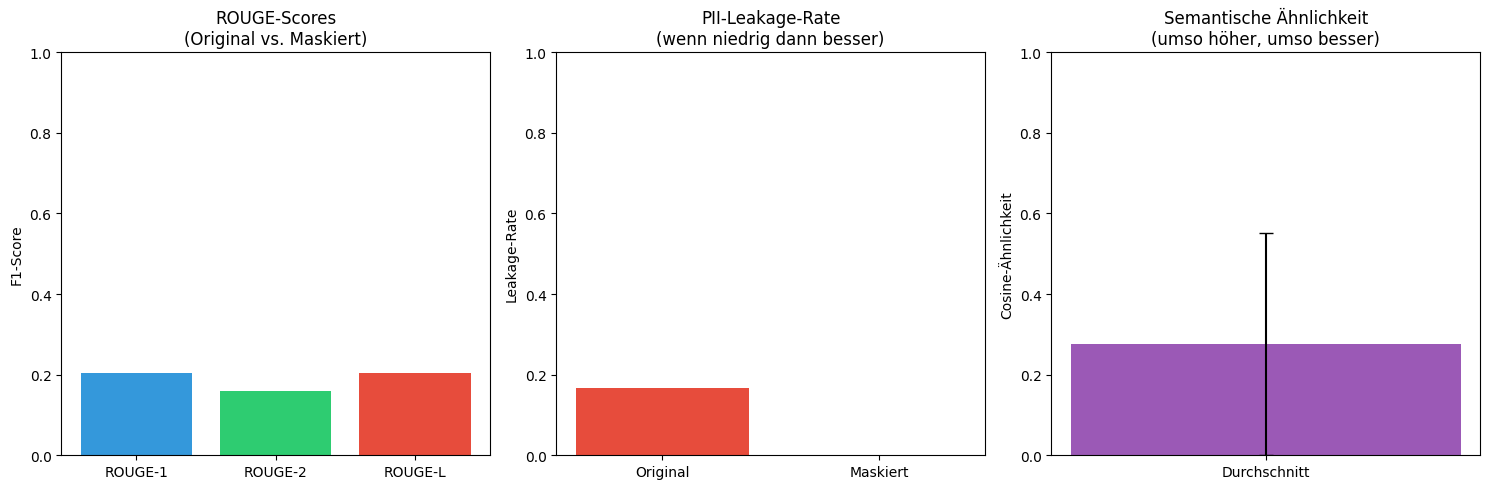

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# --> ROUGE-Scores
rouge_data = {
    'ROUGE-1': np.mean([r['rouge_scores']['rouge1_f1'] for r in results]),
    'ROUGE-2': np.mean([r['rouge_scores']['rouge2_f1'] for r in results]),
    'ROUGE-L': np.mean([r['rouge_scores']['rougeL_f1'] for r in results])
}
axes[0].bar(rouge_data.keys(), rouge_data.values(), color=['#3498db', '#2ecc71', '#e74c3c'])
axes[0].set_ylabel('F1-Score')
axes[0].set_title('ROUGE-Scores\n(Original vs. Maskiert)')
axes[0].set_ylim(0, 1)

# PII-Leakage --> Vergleich
leakage_data = {
    'Original': np.mean([r['leakage_original']['leakage_rate'] for r in results]),
    'Maskiert': np.mean([r['leakage_redacted']['leakage_rate'] for r in results])
}
colors = ['#e74c3c', '#2ecc71']
axes[1].bar(leakage_data.keys(), leakage_data.values(), color=colors)
axes[1].set_ylabel('Leakage-Rate')
axes[1].set_title('PII-Leakage-Rate\n(wenn niedrig dann besser)')
axes[1].set_ylim(0, 1)

# wie semantische ähnlich?
sim_values = [r['semantic_similarity'] for r in results]
axes[2].bar(['Durchschnitt'], [np.mean(sim_values)], color='#9b59b6')
axes[2].errorbar(['Durchschnitt'], [np.mean(sim_values)], 
                 yerr=[np.std(sim_values)], fmt='none', color='black', capsize=5)
axes[2].set_ylabel('Cosine-Ähnlichkeit')
axes[2].set_title('Semantische Ähnlichkeit\n(umso höher, umso besser)')
axes[2].set_ylim(0, 1)

plt.tight_layout()
plt.savefig(project_root / 'exports' / 'quality_comparison.png', dpi=150)
plt.show()

### 4.3 Ergebnistabelle

In [52]:
results_df = pd.DataFrame([
    {
        'Anfrage': r['query'][:40] + '...' if len(r['query']) > 40 else r['query'],
        'ROUGE-1': f"{r['rouge_scores']['rouge1_f1']:.3f}",
        'ROUGE-L': f"{r['rouge_scores']['rougeL_f1']:.3f}",
        'Leakage (Orig.)': f"{r['leakage_original']['leakage_rate']*100:.1f}%",
        'Leakage (Mask.)': f"{r['leakage_redacted']['leakage_rate']*100:.1f}%",
        'Sem. Ähnlichkeit': f"{r['semantic_similarity']:.3f}"
    }
    for r in results
])

display(results_df)

,Anfrage,ROUGE-1,ROUGE-L,Leakage (Orig.),Leakage (Mask.),Sem. Ähnlichkeit
0,Welche Kontaktdaten hat der Kunde?,0.312,0.312,0.0%,0.0%,0.552
1,Was ist die Beurteilung der Mitarbeiteri...,0.098,0.098,33.3%,0.0%,0.000


---

## 5. Analyse mit lokalem LLAMA


In [57]:
llm_configs = [
    {"name": "Lokales Llama (Q4_K_M)", "type": "local", "available": LLM_AVAILABLE},
]

def test_llm_with_pii_redaction(config: dict, test_text: str) -> dict:
    # Ohne redaction
    if config['available']:
        response_raw = query_llm("Was sind die Kontaktdaten?", test_text)
    else:
        response_raw = "[LLM nicht verfügbar - Simulation]"
    
    # Mit redaction
    result = redactor_full.redact(test_text)
    if config['available']:
        response_redacted = query_llm("Was sind die Kontaktdaten?", result.redacted_text)
    else:
        response_redacted = "[LLM nicht verfügbar - Simulation mit Platzhaltern]"
    
    return {
        "config": config['name'],
        "pii_found": len(result.matches),
        "response_raw": response_raw,
        "response_redacted": response_redacted
    }

# Test
test_text = "Kontaktiere Hans Meyer unter hans.meyer@test.de oder 0170-9876543"

for config in llm_configs:
    if config['available']:
        result = test_llm_with_pii_redaction(config, test_text)
        print(f"PIIs gefunden: {result['pii_found']}")
        print(f"Antwort (raw): {result['response_raw']}")
        print(f"Antwort (redacted): {result['response_redacted']}")

PIIs gefunden: 3
Antwort (raw): Du kannst Hans Meyer erreichen unter hans.meyer@test.de oder 0170-9876543. Alternativ kannst du auch direkt mit ihm sprechen, wenn du die Telefonnummer von Hans Meyer in deiner Adressbuch oder Telefonbuch einträgst. Alternativ kannst du auch einen Kurierdienst beauftragen, um einen Brief an Hans Meyer zu senden. Alternativ kannst du auch die Adresse von Hans Meyer in deinem Adressbuch oder Telefonbuch eintragen und einen Brief an Hans Meyer persönlich schicken. Alternativ kannst du auch die Website von Hans Meyer besuchen und einen Kontaktformular ausfüllen, um Hans Meyer zu kontaktieren. Alternativ kannst du auch eine SMS an Hans Meyer senden, um ihn zu kontaktieren. Alternativ kannst du auch eine E-Mail an Hans Meyer schicken, um ihn zu kontaktieren. Alternativ kannst du auch einen Brief an Hans Meyer schicken, indem du ihn persönlich aufsuchst.
Antwort (redacted): [NAME_1] kann unter [EMAIL_1] oder [PHONE_1] erreicht werden.


---

## Quellen und Referenzen

1. **Carlini, N., Tramer, F., Wallace, E., Jagielski, M., Herbert-Voss, A., Lee, K., ... & Raffel, C. (2021).** "Extracting Training Data from Large Language Models." *30th USENIX Security Symposium.* [https://arxiv.org/abs/2012.07805](https://arxiv.org/abs/2012.07805)

2. **Microsoft Presidio** - Open-Source Framework für PII-Erkennung und Anonymisierung. [https://github.com/microsoft/presidio](https://github.com/microsoft/presidio)

3. **spaCy** - Industrial-Strength Natural Language Processing. [https://spacy.io/](https://spacy.io/)

4. **DSGVO (Datenschutz-Grundverordnung)** - Verordnung (EU) 2016/679 des Europäischen Parlaments und des Rates.

#### Statistiken exportieren

In [56]:
final_stats = {
    "total_documents_processed": len(rag_documents),
    "total_pii_found": sum(d['pii_found'] for d in redacted_documents),
    "average_pii_per_doc": np.mean([d['pii_found'] for d in redacted_documents]),
    "quality_metrics": {
        "avg_rouge1": np.mean([r['rouge_scores']['rouge1_f1'] for r in results]),
        "avg_leakage_reduction": leakage_data['Original'] - leakage_data['Maskiert'],
        "avg_semantic_similarity": np.mean(sim_values)
    },
    "llm_available": LLM_AVAILABLE,
    "ner_available": NER_AVAILABLE
}

stats_path = project_root / "exports" / "notebook_01_stats.json"
with open(stats_path, "w", encoding="utf-8") as f:
    json.dump(final_stats, f, indent=2)